In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Statistics
using Plots
using DelimitedFiles
using DataFrames
using ProgressMeter
using StatsPlots
Plots.scalefontsizes(2)
Threads.nthreads()

1

# Result (fix Bzero) - best model we have

In [7]:
# Scale by gender, fit male clearance prefactor
fitting_index =
    [1; 13; 29;              # S4, VtshMax, k05
    31; 37;                  # A0, k3
    49; 50; 51; 52; 53; 54;  # hill function parameters
    65; 66;                  # reference male/female BMI
    78; 79; 80]              # male/female ref height, male clearnace prefactor
initial_guess = [0.0019892210815454564, 0.012318557740933649, 0.207, 78.03368752668696,
    0.06578735870878696, 3.3739342983833187, 4.39393376334155, 7.183642942358456, 8.91034232003827,
    6.863194346722813, 18.848701766376884, 23.929032682987728, 22.5, 1.77, 1.63, 1.0]
train_minimizer = [0.0027785399344213424, 0.012101809339860641, 0.18497233961350687, 
    219.7085301388135, 0.05878693503356448, 3.001011022378159, 3.0947116902044804, 
    5.674773816316946, 6.290803221796369, 8.498343729591872, 14.366644969261456, 
    21.82854404275587, 22.990508452015362, 1.7608716659237555, 1.6696106891941103, 
    1.0499391485135692]
fixed_parameters = Tuple{Int64,Float64}[]
scale_plasma_ode = true
scale_slow_ode = false
scale_fast_ode = false
scale_allometric_exponent = false
scale_clearance_by_gender = true;
dir = "./fix_A0/"
isdir(dir) || mkdir(dir)

true

# FT4 vs residual thyroid function

+ jonklaas FT4 = ng/dL
+ Thyrosim T4 units = mcg/L

According to Simon, we have
$$FT4 (ng/L) = FT4 (mols) * 777/Vp * 1000 * 0.45$$
$$FT3 (ng/L) = FT3 (mols) * 651/Vp * 1000 * 0.50$$

where the FT4 on the right is the 4th order polynomial in Thyrosim's internal equations. Thyrosim outputs TT4 $(\mu mol)$ in $q1$, which we will plug into the polynomial to get $FT4 (\mu mol)$. Then we convert that to Jonklaas's units $FT4 (ng/dL)$. Finally, to get ng/dL, we have
$$\frac{1ng}{dL} = \frac{1 ng}{L} * \frac{L}{10 dL} = \frac{1}{10} \frac{ng}{dL}$$

In [3]:
"""
Converts TT4 (μmol, Thyrosim output q1) to FT4 (ng/dL, jonklaas's units) 
"""
function TT4_to_FT4(TT4::Float64, Vp::Float64)
    return FT4(TT4) * 777 / Vp * 1000 * 0.45 / 10
end

"""
Converts TT4 (μmol) to FT4 (μmol) using Thyrosim's internal 4th order polynomial
"""
function FT4(TT4::Float64)
    return (0.000289 + (0.000214 * TT4) + (0.000128 * TT4^2) - (8.83e-6 * TT4^3)) * TT4
end

FT4

# Female

In [4]:
sex = false # 1 = male, 0 = female
T4dose = 0.0 # mcg
normal_TSH, normal_T4, normal_T3 = Float64[], Float64[], Float64[]
skinny_TSH, skinny_T4, skinny_T3 = Float64[], Float64[], Float64[]
obese_TSH, obese_T4, obese_T3 = Float64[], Float64[], Float64[]
normal_Vp, skinny_Vp, obese_Vp = Float64[], Float64[], Float64[]
RTFs = [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


# normal female patient
bmi = 23
h = 1.6
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(normal_T4, t4[end])
    push!(normal_T3, t3[end])
    push!(normal_TSH, tsh[end])
    push!(normal_Vp, sol.prob.p[47])
end

# skinny female patient
bmi = 17
h = 1.6
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(skinny_T4, t4[end])
    push!(skinny_T3, t3[end])
    push!(skinny_TSH, tsh[end])
    push!(skinny_Vp, sol.prob.p[47])
end

# obese female patient
bmi = 35
h = 1.6
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(obese_T4, t4[end])
    push!(obese_T3, t3[end])
    push!(obese_TSH, tsh[end])
    push!(obese_Vp, sol.prob.p[47])
end

In [5]:
[RTFs normal_T3 normal_T3 normal_TSH normal_Vp skinny_Vp obese_Vp]

10×7 Array{Float64,2}:
 0.0    2.94101e-6  2.94101e-6  866.19     2.79898  2.50055  3.27347
 0.001  0.54699     0.54699     457.619    2.79898  2.50055  3.27347
 0.01   0.714215    0.714215     66.322    2.79898  2.50055  3.27347
 0.02   0.760545    0.760545     36.5      2.79898  2.50055  3.27347
 0.05   0.825063    0.825063     16.5574   2.79898  2.50055  3.27347
 0.1    0.879137    0.879137      9.15055  2.79898  2.50055  3.27347
 0.2    0.946639    0.946639      5.14538  2.79898  2.50055  3.27347
 0.3    0.999109    0.999109      3.74512  2.79898  2.50055  3.27347
 0.4    1.04773     1.04773       3.03168  2.79898  2.50055  3.27347
 0.5    1.09315     1.09315       2.59848  2.79898  2.50055  3.27347

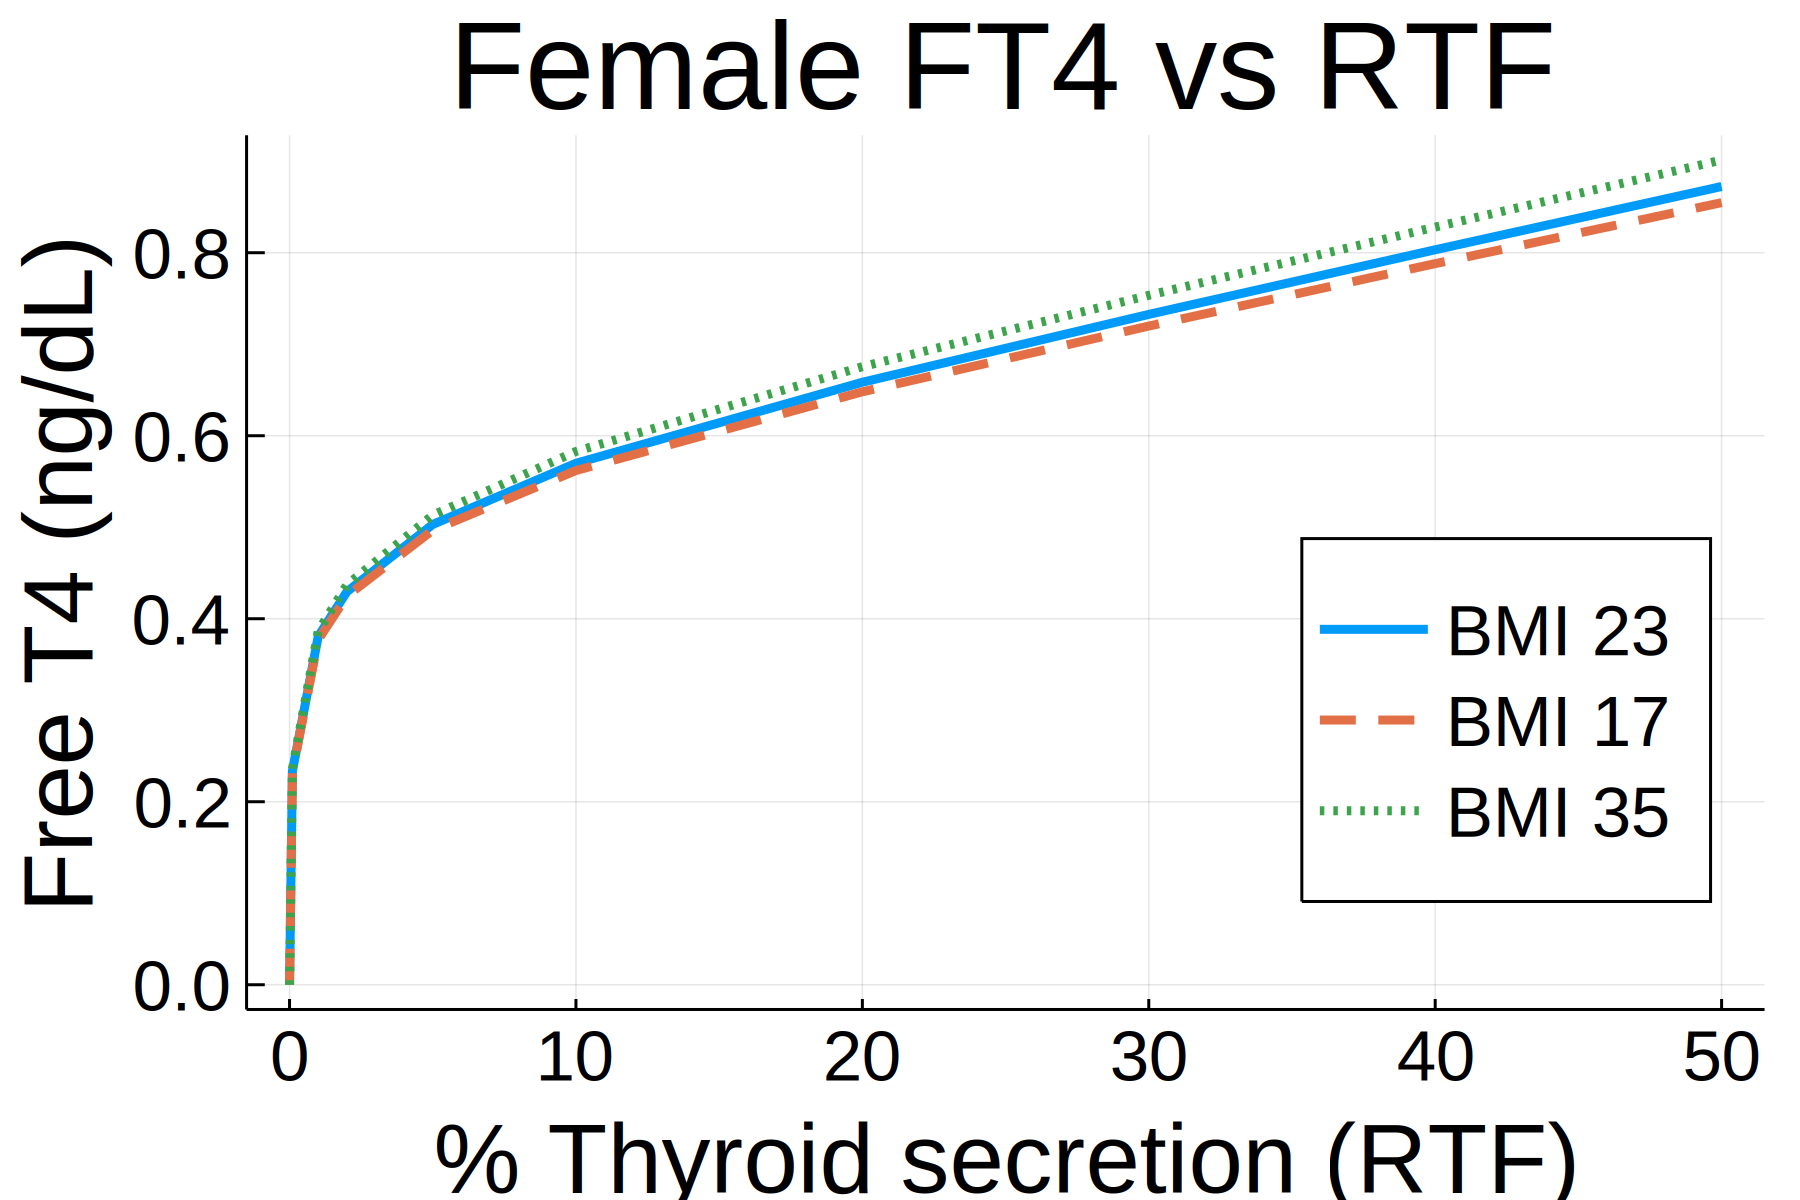

In [21]:
normal_FT4 = [TT4_to_FT4(normal_T4[i], normal_Vp[i]) for i in 1:length(normal_T4)]
skinny_FT4 = [TT4_to_FT4(skinny_T4[i], skinny_Vp[i]) for i in 1:length(skinny_T4)]
obese_FT4 = [TT4_to_FT4(obese_T4[i], obese_Vp[i]) for i in 1:length(obese_T4)]

# TT4 plot
# xticks = [string(i) for i in 0:10:50]
# t4_plot = plot(RTFs, normal_T4, label="BMI 23", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:solid, title="Female FT4 vs RTF",
#     xticks = (0.0:0.1:0.5, xticks), legend=:bottomright)
# plot!(t4_plot, RTFs, skinny_T4, label="BMI 17", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:dash)
# plot!(t4_plot, RTFs, obese_T4,label="BMI 35", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:dot)

# FT4 plot
xticks = [string(i) for i in 0:10:50]
t4_plot = plot(RTFs, normal_FT4, label="BMI 23", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:solid, title="Female FT4 vs RTF",
    xticks = (0.0:0.1:0.5, xticks), legend=:bottomright, dpi=300)
plot!(t4_plot, RTFs, skinny_FT4, label="BMI 17", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:dash)
plot!(t4_plot, RTFs, obese_FT4,label="BMI 35", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:dot)

In [22]:
savefig(t4_plot, dir * "female_ft4_RTF_plot.png")

# Male

In [13]:
sex = true # 1 = male, 0 = female
T4dose = 0.0 # mcg
normal_TSH, normal_T4, normal_T3 = Float64[], Float64[], Float64[]
skinny_TSH, skinny_T4, skinny_T3 = Float64[], Float64[], Float64[]
obese_TSH, obese_T4, obese_T3 = Float64[], Float64[], Float64[]
normal_Vp, skinny_Vp, obese_Vp = Float64[], Float64[], Float64[]
RTFs = [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


# normal male patient
bmi = 23
h = 1.76
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(normal_T4, t4[end])
    push!(normal_T3, t3[end])
    push!(normal_TSH, tsh[end])
    push!(normal_Vp, sol.prob.p[47])
end

# skinny male patient
bmi = 17
h = 1.76
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(skinny_T4, t4[end])
    push!(skinny_T3, t3[end])
    push!(skinny_TSH, tsh[end])
    push!(skinny_Vp, sol.prob.p[47])
end

# obese male patient
bmi = 35
h = 1.76
w = bmi * h^2
for rtf in RTFs
    dial = [rtf; 0.88; rtf; 0.88]
    sol = simulate(h, w, sex, days=50, dial=dial, T4dose=T4dose,
        warmup=true, fitting_index=fitting_index, parameters=train_minimizer,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode, scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
#     t4 = 777.0 * sol[1, :] / sol.prob.p[47] # for plotting TT4
    t4 = sol[1, :] # for plotting FT4
    t3 = 651.0 * sol[4, :] / sol.prob.p[47]
    tsh = 5.6 * sol[7, :] / sol.prob.p[48]
    push!(obese_T4, t4[end])
    push!(obese_T3, t3[end])
    push!(obese_TSH, tsh[end])
    push!(obese_Vp, sol.prob.p[47])
end

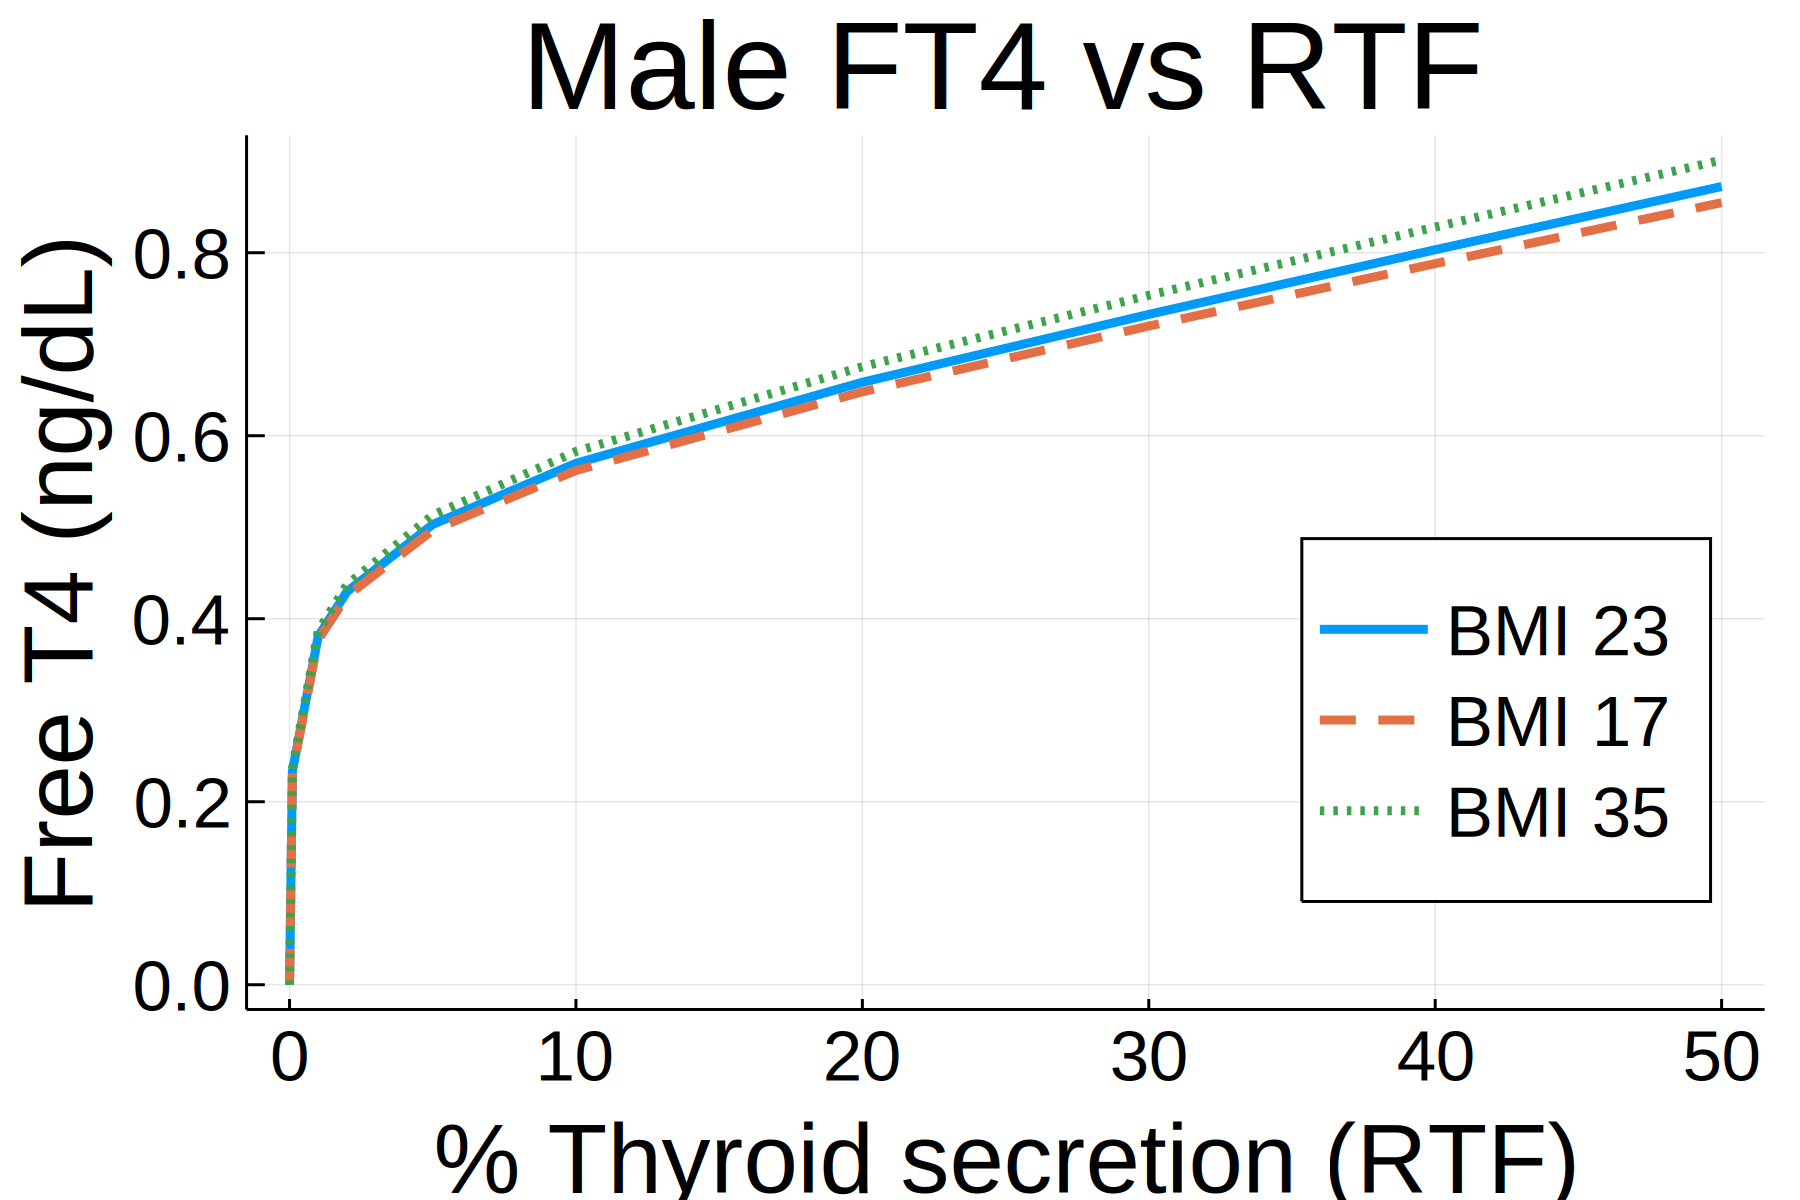

In [18]:
normal_FT4 = [TT4_to_FT4(normal_T4[i], normal_Vp[i]) for i in 1:length(normal_T4)]
skinny_FT4 = [TT4_to_FT4(skinny_T4[i], skinny_Vp[i]) for i in 1:length(skinny_T4)]
obese_FT4 = [TT4_to_FT4(obese_T4[i], obese_Vp[i]) for i in 1:length(obese_T4)]

# TT4 plot
# xticks = [string(i) for i in 0:10:50]
# t4_plot = plot(RTFs, normal_T4, label="BMI 23", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:solid, title="Female FT4 vs RTF",
#     xticks = (0.0:0.1:0.5, xticks), legend=:bottomright)
# plot!(t4_plot, RTFs, skinny_T4, label="BMI 17", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:dash)
# plot!(t4_plot, RTFs, obese_T4,label="BMI 35", xlabel="% Thyroid secretion (RTF)",
#     ylabel="Free T4 (dg/dL)", w=3, linestyle=:dot)

# FT4 plot
xticks = [string(i) for i in 0:10:50]
t4_plot = plot(RTFs, normal_FT4, label="BMI 23", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:solid, title="Male FT4 vs RTF",
    xticks = (0.0:0.1:0.5, xticks), legend=:bottomright, dpi=300)
plot!(t4_plot, RTFs, skinny_FT4, label="BMI 17", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:dash)
plot!(t4_plot, RTFs, obese_FT4,label="BMI 35", xlabel="% Thyroid secretion (RTF)",
    ylabel="Free T4 (ng/dL)", w=3, linestyle=:dot)

In [19]:
savefig(t4_plot, dir * "male_ft4_RTF_plot.png")

In [20]:
;open .

# Convert PNG to JPG

https://png2jpg.com/